In [1]:
# 只读取测试数据，对测试数据进行完整的预测
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [2]:
# 读取数据
x_test_bow = np.load('./processed_data/xtest_bow.npy')
x_test_tf = np.load('./processed_data/xtest_tf.npy')
y_test_bow_tf = np.load('./processed_data/ytest.npy')
x_test_vec = np.load('./processed_data/xtest_vec.npy')
y_test_vec = np.load('./processed_data/ytest_vec.npy')

In [3]:
# 读取word2idx文件
import pickle
with open('./models/word2idx.pkl','rb') as f:
    word2idx = pickle.load(f)

In [4]:
# 读取模型


# LSTM 模型测试

In [5]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, CPU is used") 

GPU is available


In [6]:
# 转换为TensorDataset
test_data_vec = TensorDataset(torch.from_numpy(x_test_vec).type(torch.Tensor), torch.from_numpy(y_test_vec).type(torch.Tensor))

batch_size = 40


# 设置drop_last 防止最后一个batch不够batch_size，导致数据量不对
test_loader_vec = DataLoader(test_data_vec, shuffle=False, batch_size=batch_size,drop_last=True)

In [7]:

class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [9]:
vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

<Figure size 640x480 with 0 Axes>

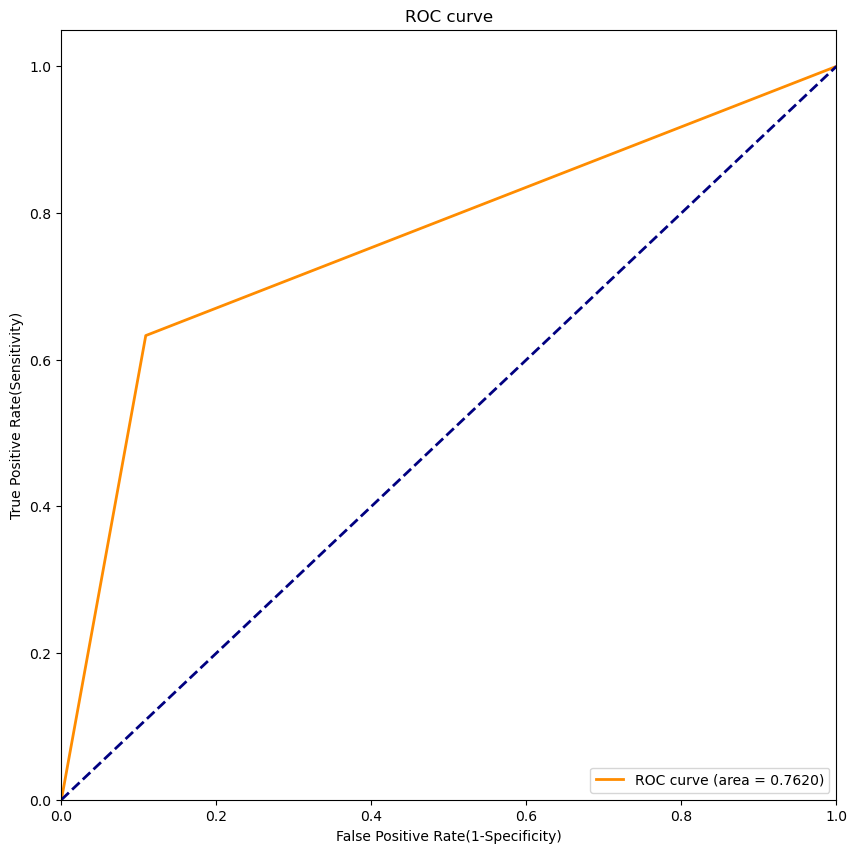

召回率： 0.6329268292682927
F1： 0.6869622766379881
AUC： 0.7620330348873108


In [10]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 读取最优模型
model.load_state_dict(torch.load('./models/state_dict.pt'))

h = model.init_hidden(batch_size)
model.eval()

# 使用召回率、F1及ROC曲线作为评价指标
# 原标签结果
y_true = np.array([])
# 预测结果
y_pred = np.array([])
for inputs, labels in test_loader_vec:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    # 将结果和预测结果放在y_true和y_pred中
    y_true = np.append(y_true,labels.cpu().detach().numpy())
    y_pred = np.append(y_pred,pred.cpu().detach().numpy())
    
# 计算召回率
recall = recall_score(y_true, y_pred)
# 计算F1
f1 = f1_score(y_true, y_pred)

# 画ROC曲线
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print('召回率：',recall)
print('F1：',f1)
print('AUC：',roc_auc)